## Background / Motivation

As avid Yelp users ourselves, we rely on Yelp to determine which restaurants to eat at and which businesses to use. The online reviews posted by the community drive many of the choices we make in frequenting businesses in the local Evanston area and when travelling. Using Yelp is a part of our everyday decision making, so we found this data to be incredibly relevant. For this project, we wanted to better understand what makes a business successful and receive high ratings, as well as develop a greater understanding of Yelp reviewer behavior on this platform that we so often use. 

## Problem statement  

1. How do average stars and review quantity vary by business category? This question aims to determine if certain types of restaurants significantly differ from others in how many reviews they get and their average rating.
2. Are there associations between business attributes and its status (open/closed)? The goal of this question is to find out if certain business attributes are more common to businesses that are now closed or businesses that are still open.
3. Are there associations between region demographics and average stars? This question examines if businesses in regions with certain demographic characteristics have significantly different ratings than their counterparts in regions with different characteristics.
4. Is there an association between Yelper review count and the rating they give? This question addresses if Yelp users might be more likely to give certain star ratings depending on how many reviews they have given.

## Data sources

We used the Yelp Open Dataset and data from the U.S. Census Bureau. The Yelp dataset contains data from 6,990,280 reviews of 150,346 businesses across 11 metropolitan areas. The dataset is divided into business data, user data, review data, tip data, and check-in data; we looked at the business, user, and review data. The business data contained all of the businesses in the Yelp data with the corresponding business attributes (rating, review count, categories, open/closed, etc.). The user data contained all yelp users including attributes like user id, name, review count, yelping since date, average stars, profile compliments. The review data contain all yelp reviews including attributes like review id, user id, business id, stars, date, text, useful votes. The U.S. Census Bureau data that we used were found in two 5-Year American Community Survey Datasets. The first dataset contained race and ethnicity measures for residents in each postal code of the United States, from which we used the measures for the proportion of residents that were Black or African American, the proportion of residents that were White, and the proportion of residents that were Hispanic. Additionally, the second dataset contained information on average income and tax filings of residents in each postal code of the United States, from which we used the measure for the mean household income.

## Stakeholders

The stakeholders for this project are the businesses, yelp users, state and local government officials, and yelp executives. With our findings, businesses will be able to improve their ratings. They will also gain insight on how to stay successful and be able to improve their online presence. Yelp users will be able to write reviews that are more useful and thus have their reviews read by more people. They will also be more aware of possible biases in reviews. State and local government officials could use our findings to inform future stimulus for businesses in higher-need areas. Lastly, yelp executives will find better ways to use user ratings to rank businesses and reviews. 

## Data quality check / cleaning / preparation 

In [299]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

#Cleaning for business dataset used in all four problems
business_data = pd.read_json('yelp_academic_dataset_business.json', lines = True)

business_data_prune = business_data.loc[(business_data['longitude'] < -90) &
                                        (business_data['longitude'] > -100) &
                                        (business_data['latitude'] > 40) &
                                        (business_data['latitude'] < 45), :].index
business_data_prune_2 = business_data.loc[(business_data['longitude'] < -74) &
                                        (business_data['longitude'] > -76) &
                                        (business_data['latitude'] > 38) &
                                        (business_data['latitude'] < 39.2), :].index

business_data_new = business_data.drop(labels = business_data_prune, axis = 0, inplace = False)
business_data_pruned = business_data_new.drop(labels = business_data_prune_2, axis = 0, inplace = False)
business_data_removed = business_data_pruned.loc[(business_data['state'].isin(['VT', 'XMS', 'SD', 'MI', 'MT', 'UT', 'NC', 
                                                                        'VI', 'MA', 'HI', 'WA', 'CO', 'TX', 'AB'])) == False, :]
postal_codes = business_data_removed['postal_code'].value_counts().to_frame()
p_codes_list = postal_codes.index
p_codes = business_data_removed.groupby('postal_code').mean()
p_codes_cleaned = p_codes.iloc[1:, :].reset_index(inplace = False)

zip_code_data = pd.read_csv('ACSST5Y2020.S1901-Data.csv')
zip_code_income = pd.DataFrame()
zip_code_income['zip_code'] = zip_code_data.loc[1:, ['NAME']]
zip_code_income['mean_household_income'] = zip_code_data.loc[1:, ['S1901_C01_013E']]
zip_code_income['zip_code'] = zip_code_income['zip_code'].apply(lambda x: x.replace('ZCTA5 ', ''))
zip_code = zip_code_income.copy()
zip_code_clean = zip_code.loc[zip_code['zip_code'].isin(p_codes_list), :].sort_values(by = 'zip_code', ascending = True)
z_codes_list = zip_code_clean['zip_code'].values

business_data_cleaned = business_data_removed.loc[(business_data_removed['postal_code'].isin(z_codes_list) == True), :]
business_ids = business_data_cleaned.business_id

#nunique() couldn't be applied to dictionaries, so dictionaries were converted to strings
business_data_cleaned_nunique = business_data_cleaned.copy()
business_data_cleaned_nunique['attributes'] = business_data_cleaned['attributes'].apply(lambda x: json.dumps(x))
business_data_cleaned_nunique['hours'] = business_data_cleaned['hours'].apply(lambda x: json.dumps(x))

#Displaying
display(business_data_cleaned.describe())
display(business_data_cleaned.isnull().sum())
display(business_data_cleaned_nunique.nunique())

,latitude,longitude,stars,review_count,is_open
count,143602.000000,143602.000000,143602.000000,143602.000000,143602.000000
mean,36.018427,-88.387682,3.602022,45.922585,0.797085
std,4.947301,14.378308,0.975937,122.953380,0.402171
min,27.555127,-120.095137,1.000000,5.000000,0.000000
25%,30.032966,-90.259671,3.000000,8.000000,1.000000
50%,38.653841,-86.029668,3.500000,15.000000,1.000000
75%,39.947503,-75.386516,4.500000,38.000000,1.000000
max,43.773686,-74.658572,5.000000,7568.000000,1.000000


business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes      12953
categories        101
hours           21813
dtype: int64

business_id     143602
name            109089
address         117147
city              1348
state               13
postal_code        920
latitude        129648
longitude       125973
stars                9
review_count      1155
is_open              2
attributes       83502
categories       80004
hours            47714
dtype: int64

There were missing values in the business dataset for attributes, categories, and hours. Only categories and hours were used by our analysis. Further data cleaning was done in hours and described in Analysis 2. For categories, we decided it was most prudent to simply ignore and remove these postal codes from the analysis (attempting to use a naive method or impute missing values as the mean of non-missing values were both inaccurate).

In [300]:
#Cleaning for Analysis 4 with user and review dataset

#import user dataset
inputFile = "yelp_academic_dataset_user.json"
N=250000

data=[]
with open(inputFile) as f:
    for i in range(0, N):
        a=f.readline()
        res = json.loads(a)
        del res['friends']
        del res['elite']
        del res['funny']
        del res['cool']
        del res['compliment_list']
        del res['compliment_funny']
        del res['compliment_cool']
        del res['compliment_plain']
        del res['compliment_cute']
        del res['compliment_hot']
        del res['compliment_more']  
        del res['compliment_note']
        del res['compliment_writer']
        del res['compliment_photos']
        data.append(res)
        
user_data=pd.DataFrame(data)

#import review dataset
inputFile2 = 'yelp_academic_dataset_review.json'

N=2300000

data2=[]
with open(inputFile2) as f:
    for i in range(0, N):
        b=f.readline()
        res = json.loads(b)
        del res['funny']
        del res['cool']
        data2.append(res)

review_data=pd.DataFrame(data2)

#Displaying
display(user_data.describe())
display(user_data.nunique())
display(review_data.describe())
display(review_data.nunique())

,review_count,useful,fans,average_stars,compliment_profile
count,250000.000000,250000.00000,250000.000000,250000.000000,250000.000000
mean,62.581684,151.01890,5.104248,3.785536,0.703224
std,176.773522,1496.08242,44.604470,0.837589,27.531195
min,0.000000,0.00000,0.000000,1.000000,0.000000
25%,6.000000,3.00000,0.000000,3.400000,0.000000
50%,16.000000,13.00000,0.000000,3.900000,0.000000
75%,47.000000,47.00000,2.000000,4.330000,0.000000
max,17473.000000,206296.00000,12497.000000,5.000000,7039.000000


user_id               250000
name                   29378
review_count            1839
yelping_since         249852
useful                  4138
fans                     601
average_stars            397
compliment_profile       265
dtype: int64

,stars,useful
count,2.300000e+06,2.300000e+06
mean,3.762033e+00,1.157963e+00
std,1.464537e+00,2.923151e+00
min,1.000000e+00,-1.000000e+00
25%,3.000000e+00,0.000000e+00
50%,4.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00
max,5.000000e+00,5.390000e+02


review_id      2300000
user_id         982424
business_id      56266
stars                5
useful             182
text           2295664
date           2288562
dtype: int64

There were no missing values in either the user or review datasets (displays of this are found in the Appendix). However, as the summary statistics of the user dataset show, there are outliers which need to be removed from the dataset. The mean review count is 62 while the maximum is more than 17,000. To ensure that these users could truly be treated as outliers, we read through the reviews written by some of these users and found that many of their reviews had no relation to the business they were reviewing and were likely bots. Thus, using Tukey's fences (shown below), outliers in the user_data dataset were removed and reviews from those users were omitted from the lines read from the review_data dataset.

In [301]:
#removing outliers by review count
q1 = np.percentile(user_data['review_count'],25)
q3 = np.percentile(user_data['review_count'],75)
intQ_range = q3-q1
Lower_fence = q1 - 1.5*intQ_range
Upper_fence = q3 + 1.5*intQ_range
Outlying_obs = user_data[(user_data.review_count<Lower_fence) | (user_data.review_count>Upper_fence)]
user_data_without_outliers = user_data[((user_data.review_count>=Lower_fence) & (user_data.review_count<=Upper_fence))]

## Exploratory Data Analysis

### Analysis 1
*By \<Keaton Olds>*

My analysis examined if there were associations between the types of businesses on Yelp and the average rating and number of reviews that those businesses received. In addition, I did the same analysis on restaurant types and average rating and number of reviews. Yelp is most widely known and used for restaurants, so I wanted to see if restaurant-type businesses followed the same trends as other businesses on Yelp. To perform this analysis, I looked at the stars, review count, and categories of each business in the dataset. The goal of this analysis was to identify which types of businesses should prioritize their online, starting with Yelp, reputation, and devote further resources to maintaining and improving it. Before I could analyze the businesses by category of business, I needed to be able to break them down by category. The business data does have a ‘category’ column, but each entry in that column is a string that is a list of categories, as businesses have multiple categories to describe both the type of business, and then the type of that specific business. For example, if we were looking at a business like Chipotle, their category entry might be: “Restaurant, Mexican, Burritos.” If I wanted to just isolate the business type, I needed to extract the substring in the string that corresponded to the restaurant type and put those values in a new column. On the Yelp blog [1], I found the list of all 22 business types that Yelp has, and I put these into a list of strings that I could use to isolate and extract the business types from the category column. Once I had this list, I used a string extract function to create a new column called “biz_type” that contained the type of business pertaining to each row. Now that I could sort and filter by business type, I first ran a value counts on the biz_type column to see which types of businesses appeared the most on Yelp; to no surprise, restaurants were by far the most abundant businesses on Yelp. I also used the value counts to narrow down the list of business types to the top ten of which appear the most to make the visualizations less crowded and more appealing. The rationale behind this was that not including a type of business outside of the top ten in frequency didn’t interfere with my insights as Yelp isn’t as significant for those types of businesses. I created a list of these top ten business types, and used .isin() to filter the data frame to include only businesses that fell into these types. Now that I could separate the businesses by business type I created two seaborn bar plots with red color scales: one had business type on the x-axis and number of reviews on the y-axis, and the other had business type on the x-axis with stars (rating) on the y-axis. For each barplot, I created a list of the business types in descending order so that the barplots would be organized by descending values.

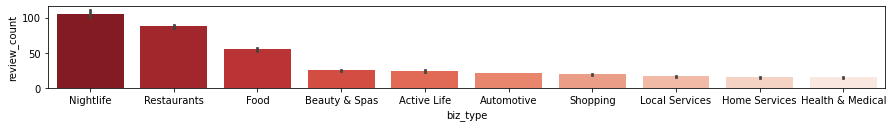

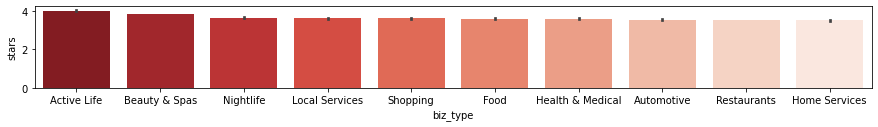

In [302]:
biz_categories = ['Active Life', 'Arts & Entertainment', 'Automotive', 'Beauty & Spas', 'Education'
                  'Event Planning & Services', 'Financial Services', 'Food', 'Health & Medical', 'Home Services',
                  'Hotels & Travel', 'Local Flavor', 'Local Services', 'Mass Media', 'Nightlife', 'Pets',
                  'Professional Services', 'Public Services & Government', 'Real Estate', 'Religious Organizations',
                  'Restaurants', 'Shopping']

business_data_cleaned['biz_type'] = business_data_cleaned['categories'].str.extract(f"({'|'.join(biz_categories)})")
business_data_cleaned.biz_type.value_counts()

top_biz = ['Restaurants','Food','Shopping','Beauty & Spas','Health & Medical','Automotive','Home Services','Local Services','Nightlife','Active Life']
biz_10 = business_data_cleaned[business_data_cleaned.biz_type.isin(top_biz)]

biz_order = biz_10[['review_count','biz_type']].groupby('biz_type').mean().sort_values(by = 'review_count',
                                            ascending= False).index.to_list()
a = sns.barplot(x="biz_type", y = 'review_count',  data=biz_10, palette = 'Reds_r', order = biz_order)
a.figure.set_figwidth(15)
a.figure.set_figheight(1.5)
plt.show()
biz_order2 = biz_10[['stars','biz_type']].groupby('biz_type').mean().sort_values(by = 'stars',
                                            ascending= False).index.to_list()
b = sns.barplot(x="biz_type", y = 'stars',  data=biz_10, palette = 'Reds_r', order = biz_order2)
b.figure.set_figwidth(15)
b.figure.set_figheight(1.5)
plt.show()

Next, I filtered the data frame that had all the business types and not just the top ten for only restaurant businesses. With this data frame, I repeated the same process outlined earlier but for restaurant type instead of business type. I found a list of all Yelp restaurant types on the same Yelp blog [1] where I found all of the business types, and created a list of these strings. I then used this list to extract the restaurant type from the categories column, and put these values in a new column called “cuisine.” I then used value counts with sort values on the cuisine column to again narrow down all of the cuisines to a top ten based on frequency. I created a list of these top ten cuisines, and used it to filter the data frame with .isin(). Finally, I created two seaborn bar plots for the restaurant cuisines: one had cuisine on the x-axis and number of reviews on the y-axis, and the other had cuisine on the x-axis with stars (rating) on the y-axis. For each barplot, I used the same code as before to create lists that I would use to have the barplots present descending values. 

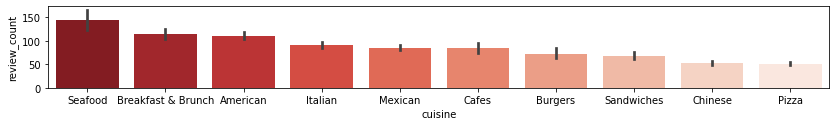

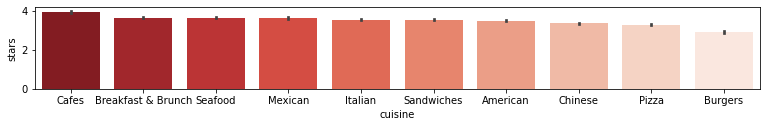

In [303]:
business_rest = business_data_cleaned[business_data_cleaned.biz_type == 'Restaurants']

cuisines = ['Afghan', 'African','American','Arabian','Argentine','Armenian',
            'Asian Fusion','Australian','Austrian','Bangladeshi','Barbeque','Basque','Belgian','Brasseries','Brazilian',
            'Breakfast & Brunch','British','Buffets','Bulgarian','Burgers','Burmese','Cafes','Cafeteria','Cajun/Creole','Cambodian','Caribbean','Catalan','Cheesesteaks','Chicken Shop',
            'Chicken Wings','Chinese','Comfort Food','Creperies','Cuban','Czech','Delis','Diners','Dinner Theater','Eritrean','Ethiopian',
            'Fast Food','Filipino','Fish & Chips','Fondue','Food Court','Food Stands','French','Game Meat','Gastropubs',
            'Georgian','German','Gluten-Free','Greek',"Guamanian",'Halal','Hawaiian','Himalayan/Nepalese',
            'Honduran','Hong Kong Style Cafe','Hot Dogs','Hot Pot','Hungarian','Iberian','Indian','Indonesian','Irish','Italian','Japanese','Kebab','Korean',
            'Kosher','Laotian','Latin American','Live/Raw Food','Malaysian','Mediterranean','Mexican','Middle Eastern','Modern European',
            'Mongolian','Moroccan','New Mexican Cuisine','Nicaraguan','Noodles','Pakistani','Pan Asia','Persian/Iranian','Peruvian',
            'Pizza','Polish','Polynesian','Pop-Up Restaurants','Portuguese','Poutineries','Russian','Salad','Sandwiches','Scandinavian',
            'Scottish','Seafood','Singaporean','Slovakian','Somali','Soul Food','Soup','Southern','Spanish','Sri Lankan','Steakhouses',
            'Supper Clubs','Sushi Bars','Syrian','Taiwanese','Tapas Bars','Tapas/Small Plates','Tex-Mex','Thai','Turkish','Ukrainian',
            'Uzbek','Vegan','Vegetarian','Vietnamese','Waffles','Wraps']

business_rest['cuisine'] = business_rest['categories'].str.extract(f"({'|'.join(cuisines)})")

business_rest.cuisine.value_counts().sort_values(ascending = False)[0:10]

top_10 = ['American','Pizza','Mexican','Sandwiches','Chinese','Italian','Breakfast & Brunch','Burgers','Seafood','Cafes']
biz_rest_10 = business_rest[business_rest.cuisine.isin(top_10)]

cuiz_order = biz_rest_10[['review_count','cuisine']].groupby('cuisine').mean().sort_values(by = 'review_count',
                                            ascending= False).index.to_list()
c = sns.barplot(x="cuisine", y = 'review_count',  data=biz_rest_10, palette = 'Reds_r', order = cuiz_order)
c.figure.set_figwidth(14)
c.tick_params(axis = 'x', labelsize=10)
c.figure.set_figheight(1.5)
plt.show()
cuiz_order2 = biz_rest_10[['stars','cuisine']].groupby('cuisine').mean().sort_values(by = 'stars',
                                            ascending= False).index.to_list()
d = sns.barplot(x="cuisine", y = 'stars',  data=biz_rest_10, palette = 'Reds_r', order = cuiz_order2)
d.figure.set_figwidth(13)
d.tick_params(axis = 'x', labelsize=10)
d.figure.set_figheight(1.5)
plt.show()

Upon approaching this analysis, I knew that the main task was going to be the process of extracting the substrings that corresponded to business type and restaurant type from the category column that was a large string. I originally attempted to solve this problem with a double for loop that iterates over every entry in the categories column, and for each entry iterates over every business type in the list of business types to see if one matches.  After some debugging, this code ran and created the new column, but there were a lot of NaN values. After trying to work through it, I couldn’t understand what wasn’t working, so I came to the conclusion that I was trying to do too much with this code and I scrapped it. My first idea to solve this problem did not work. I was able to find a source on the internet to assist me with this issue [2].


### Analysis 2
*By \<Cindy Wu>*

For my analysis, I looked into whether certain factors related to whether a business shut down. The specific business attributes I looked at were: number of reviews, average rating, parking availability, and hours of operation. The motivation behind this analysis was trying to see if closed businesses exhibited any patterns in the way they operated (ex. Weren’t open on weekends), in which case our recommendations would be for the open businesses to not do those things. In terms of what I specifically did, for each business attribute of interest, I first manipulated the dataframe to make it easier to analyze based on personal preference. For example, instead of using 1’s and 0’s to indicate whether a business is still open or shut down, I changed it to the strings “open” and “closed”. Then I subsetted the data into open and closed businesses to do analysis for each of them separately. From there, I constructed graphs to display the data. For numerical values (ex. number of reviews, average rating, and total number of hours open per week), I used a double histogram to show the distribution for open and closed businesses on the same graph. Below are the double histograms showing the distribution of total reviews and average rating, respectively. The lighter pink is for open businesses, and the darker shade is for closed/shut-down businesses.

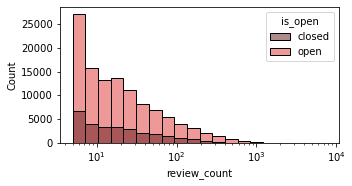

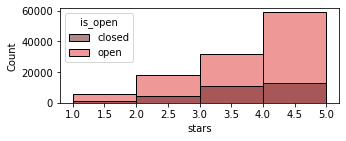

In [304]:
business_data_cleaned['is_open'] = business_data_cleaned['is_open'].apply(lambda x: 'open' if x==1 else 'closed')
open_restaurants = business_data_cleaned[business_data_cleaned['is_open'] == 'open']
closed_restaurants = business_data_cleaned[business_data_cleaned['is_open'] == 'closed']

a = sns.histplot(data=business_data_cleaned, x="review_count", palette=['#611717',"#e03333"], log_scale=True, bins=20,hue='is_open',legend=True)
a.figure.set_figheight(2.5)
plt.show()
a = sns.histplot(data=business_data_cleaned, x="stars", palette=['#611717',"#e03333"], bins=4, hue='is_open',legend=True)
a.figure.set_figheight(1.75)
plt.show()

From just a basic glance over the data, I could tell that I would have some trouble just getting the data for parking, since the parking information was pretty embedded in the “attributes” column. Each row of the “attributes” column had a dictionary. Each key of the dictionary represented a different attribute, for example whether the business accepts credit card or offers parking. The corresponding values for the parking key were dictionaries as well, with the keys being types of parking (garage, street, lot, validated, valet, none) and the values being True or False indicating whether the business offered that type of parking. Writing code that allowed me to iterate through these dictionaries and get the counts of each type of parking offered for each business was the main challenge I encountered. To break down my approach, I first created a for loop that checked whether the business offered parking, and created a new column "park" that contains dictionaries containing information on the TYPE of parking offerred as well as a new column "has parking" that just says True if it offers parking. Then, I subsetted the dataset to only include businesses that had parking. I also changed the datatype of the "park" column entries to be dictionaries, not strings. I then created separate columns for each of the types of parking (garage, street, lot, validated, valet, none) and used True or False to indicate whether that business offered that type of parking. I then summed up those columns to find the proportion of businesses that had each type of parking and made 100% stacked barplots using those proportions.  I thought this approach would be successful because these types of graphs made it easy to compare the business attributes for open and closed businesses, since it showed the distribution for open and closed businesses pretty much side by side.

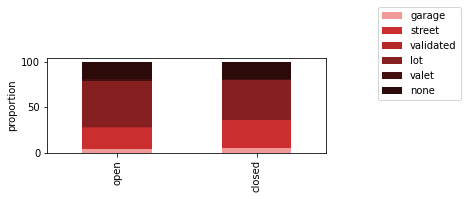

In [294]:
business_data_cleaned = business_data_cleaned.reset_index(drop=True)
for i in range(business_data_cleaned.shape[0]):
    if business_data_cleaned.loc[i,'attributes'] is not None:
        for key,value in business_data_cleaned.loc[i,'attributes'].items():
            if key=='BusinessParking':
                business_data_cleaned.loc[i,'park'] = value  
                business_data_cleaned.loc[i,'has parking'] = True

yelp_parking = business_data_cleaned[business_data_cleaned['has parking']==True]
yelp_parking.reset_index(drop=True,inplace=True)

yelp_parking['park'] = yelp_parking['park'].apply(lambda x: eval(x))

for i in range(yelp_parking.shape[0]):
    if yelp_parking.loc[i,'park'] is not None:
        for key,value in yelp_parking.loc[i,'park'].items(): 
            if value==True:
                yelp_parking.loc[i,key] = True
            else:
                yelp_parking.loc[i,key] = False
                
open_yelp_parking = yelp_parking[yelp_parking['is_open'] == 'open']
closed_yelp_parking = yelp_parking[yelp_parking['is_open'] == 'closed']
open_proportion = pd.DataFrame(open_yelp_parking.iloc[:,-5:].sum(axis=0)/open_yelp_parking.shape[0]) 
closed_proportion = pd.DataFrame(closed_yelp_parking.iloc[:,-5:].sum(axis=0)/closed_yelp_parking.shape[0])
result = pd.concat([open_proportion,closed_proportion],axis=1)
result.columns = ['open','closed']
result = result.transpose()
result['none'] = 1-result.sum(axis=1)
result = result *100
result.transpose()
ax = result.plot.bar(stacked=True,ylabel ='proportion',color=['#f09999','#ca2e2e','#b32929','#861f1f','#430f0f','#2d0a0a'])
ax.legend(loc='lower right', bbox_to_anchor=(1.5, 0.5))
ax.figure.set_figheight(1.75)
plt.show()

For hours of operation, I first subsetted the data to only include businesses who reported their hours. Then, for open and closed businesses (separately), I figured out how many total hours they were open in a given week. This included changing the datatype using datetime, and finding the difference between the hours they reported. For businesses that closed at times like 2am, I changed that value from 2 to 26 so that the total number of hours open would be correct. For example, if the business opened from 8pm to 2am, the data would have reported it as 20 to 2. However, because of the way I wrote my code initially, it would report that they were open for 2-20=-18 hours which didn't make sense. So I changed it so that the data would report it as 20 to 26 (since it's 24+2). This way, the code would report that they were open for 26-20=6 hours, which is correct. Then, I just graphed the distribution of total hours opened in a double histogram.

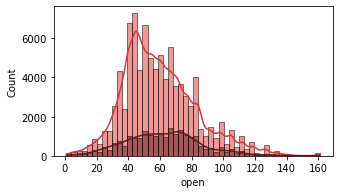

In [293]:
yelp_hours_notNone = business_data_cleaned[business_data_cleaned['hours'].apply(lambda x: True if x is not None else False)]

# OPEN STORES 

from datetime import datetime
import math 

FMT = '%H:%M'
yelp_hours_notNone.reset_index(drop=True,inplace=True)
open_hr = yelp_hours_notNone[yelp_hours_notNone['is_open']=='open']
open_hr.reset_index(drop=True,inplace=True)


list_of_totalhours_open = []
for i in range(open_hr.shape[0]):
    totalhour = 0
    for key,value in open_hr['hours'][i].items(): 
        if datetime.strptime(value.split('-')[1],FMT).hour < datetime.strptime(value.split('-')[0],FMT).hour:
            start, end = value.split('-')
            start_hours, start_minutes = start.split(':')
            end_hours, end_minutes = end.split(':')
            endtime = 24 + int(end_hours)
            starttime = int(start_hours)
        else:
            start, end = value.split('-')
            end_hours, end_minutes = end.split(':')
            start_hours, start_minutes = start.split(':')
            starttime = int(start_hours)
            endtime = int(end_hours)
        hours =  abs(endtime - starttime)
        totalhour += hours
    list_of_totalhours_open.append(totalhour)
    
# CLOSED STORES 

from datetime import datetime
import math 

FMT = '%H:%M'
yelp_hours_notNone.reset_index(drop=True,inplace=True)
closed_hr = yelp_hours_notNone[yelp_hours_notNone['is_open']=='closed']
closed_hr.reset_index(drop=True,inplace=True)


list_of_totalhours_closed = []
for i in range(closed_hr.shape[0]):
    totalhour = 0
    for key,value in closed_hr['hours'][i].items(): ####### change back to i
        if datetime.strptime(value.split('-')[1],FMT).hour < datetime.strptime(value.split('-')[0],FMT).hour:
            start, end = value.split('-')
            start_hours, start_minutes = start.split(':')
            end_hours, end_minutes = end.split(':')
            endtime = 24 + int(end_hours)
            starttime = int(start_hours)
        else:
            start, end = value.split('-')
            end_hours, end_minutes = end.split(':')
            start_hours, start_minutes = start.split(':')
            starttime = int(start_hours)
            endtime = int(end_hours)
        hours =  abs(endtime - starttime)
        totalhour += hours
    list_of_totalhours_closed.append(totalhour)
    
df_hours_open = pd.DataFrame(list_of_totalhours_open)
df_hours_open.columns = ['open']
df_hours_open = df_hours_open[df_hours_open['open']!=0]

df_hours_closed = pd.DataFrame(list_of_totalhours_closed)
df_hours_closed.columns = ['closed']
df_hours_closed = df_hours_closed[df_hours_closed['closed']!=0]

a = sns.histplot(data=df_hours_open, x="open", color="#e03333", label="open", bins=50,kde=True)
a = sns.histplot(data=df_hours_closed, x="closed", color="#611717", label="closed", bins=50,kde=True)
a.figure.set_figheight(2.75)

Lastly, I wanted to get information on whether these businesses were open on weekends. First, I found the businesses that had their hours reported. Then I did a simple for loop to go through all the businesses and I tallied up whether they were open only on saturday, only open on sunday, open both saturday and sunday, or open neither days. I then found the necessary proportions, reshaped the data to be easier to graph, and graphed it.

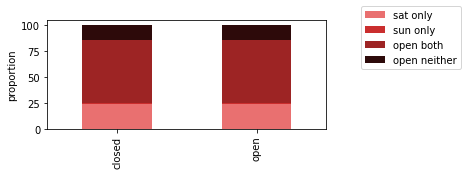

In [274]:
open_hours = yelp_hours_notNone[yelp_hours_notNone['is_open']=='open']
open_hours.reset_index(drop=True,inplace=True)
closed_hours = yelp_hours_notNone[yelp_hours_notNone['is_open']=='closed']
closed_hours.reset_index(drop=True,inplace=True)

# OPEN BUSINESSES
open_num_satonly = 0
open_num_sunonly = 0
open_num_both = 0
open_num_none = 0
open_total = open_hours.shape[0]
for i in range(open_hours.shape[0]): # go thru each row 
    has_sat = False
    has_sun = False
    list_of_days = []
    for key,value in open_hours.loc[i,'hours'].items(): # within a single dictionary
        list_of_days.append(key) 
    if 'Saturday' in list_of_days:
        has_sat = True
    if 'Sunday' in list_of_days:
        has_sun = True    
    if has_sat == False and has_sun == True:
        open_num_sunonly +=1
    elif(has_sat == True and has_sun == False):
        open_num_satonly +=1
    elif(has_sat == True and has_sun ==True):
        open_num_both +=1
    else:
        open_num_none +=1
        
# CLOSED BUSINESSES

closed_num_satonly = 0
closed_num_sunonly = 0
closed_num_both = 0
closed_num_none = 0
closed_total = closed_hours.shape[0]

for i in range(closed_hours.shape[0]): # go thru each row 
    has_sat = False
    has_sun = False
    list_of_days = []
    for key,value in open_hours.loc[i,'hours'].items(): # within a single dictionary
        list_of_days.append(key) 
    if 'Saturday' in list_of_days:
        has_sat = True
    if 'Sunday' in list_of_days:
        has_sun = True    
    if has_sat == False and has_sun == True:
        closed_num_sunonly +=1
    elif(has_sat == True and has_sun == False):
        closed_num_satonly +=1
    elif(has_sat == True and has_sun ==True):
        closed_num_both +=1
    else:
        closed_num_none +=1
        
closedprop = pd.DataFrame([closed_num_satonly/closed_total,
                           closed_num_sunonly/closed_total,
                           closed_num_both/closed_total,
                           closed_num_none/closed_total])
openprop = pd.DataFrame([open_num_satonly/open_total,
                         open_num_sunonly/open_total,
                         open_num_both/open_total,
                         open_num_none/open_total])
weekend_prop = pd.concat([openprop,closedprop],axis=1)
weekend_prop.columns = ['open','closed']
weekend_prop = result.transpose()
weekend_prop = weekend_prop *100
weekend_prop['% difference'] = weekend_prop['open'].subtract(weekend_prop['closed'])
closedprop = closedprop.transpose()
closedprop.columns = ['sat only','sun only','open both','open neither']
openprop = openprop.transpose()
openprop.columns = ['sat only','sun only','open both','open neither']
weekends = pd.concat([closedprop,openprop])
weekends = weekends.transpose()
weekends.columns = ['closed','open']
weekends = weekends.transpose()
weekends = weekends *100
ax = weekends.plot.bar(stacked=True,ylabel ='proportion',color = ['#e97070','#ca2e2e','#9d2424','#2d0a0a'])
ax.legend(loc='lower right', bbox_to_anchor=(1.5, 0.5))
ax.figure.set_figheight(1.75)

### Analysis 3
*By \<Michael Kim>*

After examining the strength of correlations between business attribute variables and the status of being open or closed, we wanted to further investigate the strength of correlations existing between region demographic variables (including race and socioeconomic variables) and the number of stars on Yelp. To do so, we took the previously cleaned dataframe and calculated the average number of stars for restaurants in each postal code, creating a new dataframe. Additionally, we used two American Community Survey 5-Year 2020 Census datasets that contained mean household income and the percentage of population by race for postal codes in the United States. This allowed us to obtain pairwise correlations between the columns containing the demographic variables and the average number of stars.

In [275]:
#Create a DataFrame object that contains the non-Yelp and Yelp variables desired for each postal code

p_codes_list = postal_codes.index
p_codes = business_data_removed.groupby('postal_code').mean()
p_codes_cleaned = p_codes.iloc[1:, :].reset_index(inplace = False)

zip_code_data = pd.read_csv('ACSST5Y2020.S1901-Data.csv')
zip_code_income['zip_code'] = zip_code_data.loc[1:, ['NAME']]
zip_code_income['mean_household_income'] = zip_code_data.loc[1:, ['S1901_C01_013E']]
zip_code_income['zip_code'] = zip_code_income['zip_code'].apply(lambda x: x.replace('ZCTA5 ', ''))
zip_code = zip_code_income.copy()
zip_code_clean = zip_code.loc[zip_code['zip_code'].isin(p_codes_list), :].sort_values(by = 'zip_code', ascending = True)
z_codes_list = zip_code_clean['zip_code'].values

p_codes_clean = p_codes_cleaned.loc[p_codes_cleaned['postal_code'].isin(z_codes_list), :]

zip_code_clean['stars'] = p_codes_clean.loc[:, 'stars'].values
zip_code_clean['is_open'] = p_codes_clean.loc[:, 'is_open'].values


hispanic_data = pd.read_csv('ACSDT5Y2020.B03003-Data.csv')
zip_code_hispanic = pd.DataFrame()
zip_code_hispanic['zip_code'] = hispanic_data.loc[1:, ['NAME']]
zip_code_hispanic['total_people'] = hispanic_data.loc[1:, ['B03003_001E']]
zip_code_hispanic['num_hispanic_people'] = hispanic_data.loc[1:, ['B03003_003E']]
zip_code_hispanic['zip_code'] = zip_code_hispanic['zip_code'].apply(lambda x: x.replace('ZCTA5 ', ''))
zip_code_hispanic_clean = zip_code_hispanic.loc[zip_code_hispanic['zip_code'].isin(z_codes_list), :]
zip_code_hispanic_clean['num_hispanic_people'] = zip_code_hispanic_clean['num_hispanic_people'].apply(lambda x: int(x))
zip_code_hispanic_clean['total_people'] = zip_code_hispanic_clean['total_people'].apply(lambda x: int(x))
zip_code_hispanic_clean['proportion_population_hispanic'] = zip_code_hispanic_clean['num_hispanic_people']/zip_code_hispanic_clean['total_people']
zip_code_clean['proportion_population_hispanic'] = zip_code_hispanic_clean.loc[:, 'proportion_population_hispanic'].values

black_data = pd.read_csv('ACSDT5Y2020.B02001-Data.csv')
zip_code_black = pd.DataFrame()
zip_code_black['zip_code'] = black_data.loc[1:, ['NAME']]
zip_code_black['total_people'] = black_data.loc[1:, ['B02001_001E']]
zip_code_black['num_black_people'] = black_data.loc[1:, ['B02001_003E']]
zip_code_black['num_white_people'] = black_data.loc[1:, ['B02001_002E']]
zip_code_black['zip_code'] = zip_code_black['zip_code'].apply(lambda x: x.replace('ZCTA5 ', ''))
zip_code_black_clean = zip_code_black.loc[zip_code_black['zip_code'].isin(z_codes_list), :]
zip_code_black_clean['num_black_people'] = zip_code_black_clean['num_black_people'].apply(lambda x: int(x))
zip_code_black_clean['num_white_people'] = zip_code_black_clean['num_white_people'].apply(lambda x: int(x))
zip_code_black_clean['total_people'] = zip_code_black_clean['total_people'].apply(lambda x: int(x))
zip_code_black_clean['proportion_population_black'] = zip_code_black_clean['num_black_people']/zip_code_black_clean['total_people']
zip_code_black_clean['proportion_population_white'] = zip_code_black_clean['num_white_people']/zip_code_black_clean['total_people']
zip_code_clean['proportion_population_black'] = zip_code_black_clean.loc[:, 'proportion_population_black'].values
zip_code_clean['proportion_population_white'] = zip_code_black_clean.loc[:, 'proportion_population_white'].values

zip_code_clean = zip_code_clean.loc[(zip_code_clean['mean_household_income'] != '-') &
                                    (zip_code_clean['mean_household_income'] != 'N'), :]
zip_code_clean['mean_household_income'] = zip_code_clean['mean_household_income'].apply(lambda x: int(x))

Initially, we anticipated problems with missing values for demographic variables for some of the postal codes or missing values of stars for restaurants before taking averages of all restaurants for postal codes within our dataframe. Although we did expect that the two American Community Survey 5-Year 2020 Census datasets would include all of the postal codes in the United States, we discovered that there were several postal codes for which they were missing. Because there was no data available from the United Status Census Bureau datasets for any of the demographic variables for these specific postal codes, we decided it was most prudent to remove these postal codes from the data (attempting to use a naive method or impute missing values as the mean of non-missing values were both inaccurate, so the corresponding rows were removed as previously described in the data cleaning section). Further, we also anticipated problems with outliers distorting the pairwise correlations between demographic variables and the average stars of restaurants in postal codes. Specifically, we believed that postal codes with a smaller number of restaurants, all of which had extremely high or low numbers of stars, would result in average stars of restaurants for those postal codes that would be outliers. This was what we ended up observing, and resulted in us deciding to remove these few outliers from the data to prevent distortion of the overall pairwise correlations between demographic variables and the average stars of restaurants in postal codes. 

In [276]:
#Removing outliers
q1 = np.percentile(zip_code_clean['stars'], 25)
q3 = np.percentile(zip_code_clean['stars'], 75)
iq_range = q3 - q1
lower_fence = q1 - 1.5*iq_range
upper_fence = q3 + 1.5*iq_range

outlying_obs = zip_code_clean[(zip_code_clean.stars < lower_fence) | (zip_code_clean.stars > upper_fence)]
zip_code_in = zip_code_clean[(zip_code_clean.stars >= lower_fence) & (zip_code_clean.stars <= upper_fence)]

Following the cleaning of data and removal of missing values, we were able to clearly analyze the pairwise correlations between demographic variables and the average stars of restaurants in postal codes. We believed that calculating the pairwise correlations and displaying them for postal codes across metropolitan areas in barplots would effectively answer the problem by being able to clearly visualize on average the demographic variables postal codes with businesses that had more successful online presences on Yelp (as measured by stars), and whether this was impacted greatly by which city the postal code was in. The four demographic variables as columns in the dataframe were the proportion of the population self-identifying as White, the proportion of the population self-identifying as Black or African-American, the proportion of the population self-identifying as Hispanic, and the mean household income. 

In [277]:
zip_code_in.corrwith(zip_code_in.stars).sort_values(ascending = False).drop(['stars', 'is_open'])

mean_household_income             0.225703
proportion_population_white       0.224653
proportion_population_hispanic   -0.010443
proportion_population_black      -0.218917
dtype: float64

From this, we discovered weak, positive correlations between the proportion of the population that self-identified as White and average stars of restaurants and between the mean household income and average stars of restaurants. Additionally, we found a weak, negative correlation between the proportion of the population that self-identified as Black or African-American and average stars of restaurants. There were no correlations between the proportion of the population that self-identified as Hispanic and the average stars. This allowed us to draw the conclusion that on average, postal codes in United States metropolitan areas that had higher proportions of White residents, lower proportions of Black or African-American residents, and higher mean household incomes had businesses with more successful online presences on Yelp, as measured by stars. To further visualize how these associations differed across each metropolitan region, the average stars of restaurants in each postal code in each metropolitan region was stored in a new dataframe. Additionally, the average of demographic variables for each postal code was also found for each metropolitan area and stored in this same dataframe. From this, we were able to generate four barplots for pairwise correlations of the four demographic variables with average stars versus metropolitan area to analyze the strength of correlations between region demographics variables and average stars, as desired by the problem. 

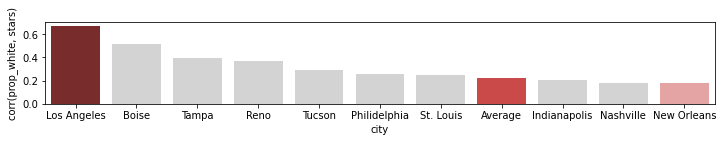

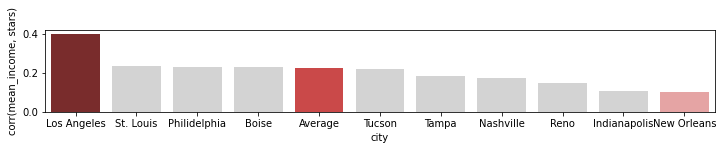

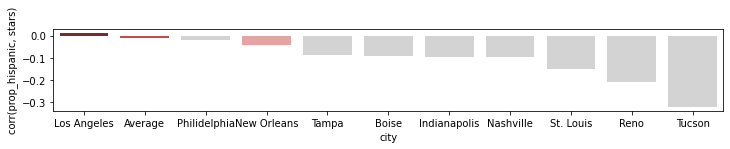

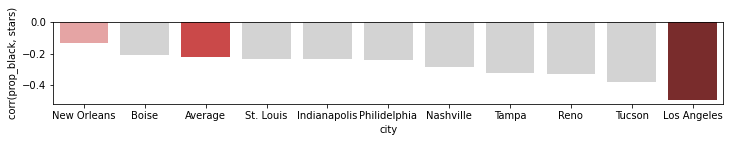

In [286]:
#Breakdown by each metropolitan area to see how the correlation coefficients vary by location

def addCityCorrelation(dictionary, dataframe, iteration):
    dictionary['corr(prop_white, stars)'][iteration] = dataframe.corrwith(dataframe.stars).sort_values(ascending = False).drop(['stars', 'is_open'])[0]
    dictionary['corr(mean_income, stars)'][iteration] = dataframe.corrwith(dataframe.stars).sort_values(ascending = False).drop(['stars', 'is_open'])[1]
    dictionary['corr(prop_hispanic, stars)'][iteration] = dataframe.corrwith(dataframe.stars).sort_values(ascending = False).drop(['stars', 'is_open'])[2]
    dictionary['corr(prop_black, stars)'][iteration] = dataframe.corrwith(dataframe.stars).sort_values(ascending = False).drop(['stars', 'is_open'])[3]

dict_zc = {}
dict_zc['city'] = ['Los Angeles', 'St. Louis', 'Tampa', 'Philidelphia', 'Nashville', 'Indianapolis', 'New Orleans', 'Tucson', 'Reno', 'Boise', 'Average']
dict_zc['corr(prop_white, stars)'] = [0] * 11
dict_zc['corr(mean_income, stars)'] = [0] * 11
dict_zc['corr(prop_hispanic, stars)'] = [0] * 11
dict_zc['corr(prop_black, stars)'] = [0] * 11

addCityCorrelation(dict_zc, zip_code_in, 10)

#Los Angeles, CA
list_la = business_data_removed.loc[business_data_removed['state'] == 'CA', 'postal_code'].unique()
zip_code_clean_la = zip_code_in.loc[zip_code_in['zip_code'].isin(list_la), :]

addCityCorrelation(dict_zc, zip_code_clean_la, 0)

#St. Louis, MO
list_mo = business_data_removed.loc[(business_data_removed['state'] == 'MO') |
                                    (business_data_removed['state'] == 'IL'), 'postal_code'].unique()
zip_code_clean_mo = zip_code_in.loc[zip_code_in['zip_code'].isin(list_mo), :]

addCityCorrelation(dict_zc, zip_code_clean_mo, 1)

#Tampa, FL
list_fl = business_data_removed.loc[(business_data_removed['state'] == 'FL'), 'postal_code'].unique()
zip_code_clean_fl = zip_code_in.loc[zip_code_in['zip_code'].isin(list_fl), :]

addCityCorrelation(dict_zc, zip_code_clean_fl, 2)

#Philidelphia, PA
list_pa = business_data_removed.loc[(business_data_removed['state'] == 'PA') |
                                    (business_data_removed['state'] == 'DE') |
                                    (business_data_removed['state'] == 'NJ'), 'postal_code'].unique()
zip_code_clean_pa = zip_code_in.loc[zip_code_in['zip_code'].isin(list_pa), :]

addCityCorrelation(dict_zc, zip_code_clean_pa, 3)

#Nashville, TN
list_tn = business_data_removed.loc[(business_data_removed['state'] == 'TN'), 'postal_code'].unique()
zip_code_clean_tn = zip_code_in.loc[zip_code_in['zip_code'].isin(list_tn), :]

addCityCorrelation(dict_zc, zip_code_clean_tn, 4)

#Indianapolis, IN
list_in = business_data_removed.loc[(business_data_removed['state'] == 'IN'), 'postal_code'].unique()
zip_code_clean_in = zip_code_in.loc[zip_code_in['zip_code'].isin(list_in), :]

addCityCorrelation(dict_zc, zip_code_clean_in, 5)

#New Orleans, LA
list_no = business_data_removed.loc[(business_data_removed['state'] == 'LA'), 'postal_code'].unique()
zip_code_clean_no = zip_code_in.loc[zip_code_in['zip_code'].isin(list_no), :]

addCityCorrelation(dict_zc, zip_code_clean_no, 6)

#Tucson, AZ
list_az = business_data_removed.loc[(business_data_removed['state'] == 'AZ'), 'postal_code'].unique()
zip_code_clean_az = zip_code_in.loc[zip_code_in['zip_code'].isin(list_az), :]

addCityCorrelation(dict_zc, zip_code_clean_az, 7)

#Reno, NV
list_nv = business_data_removed.loc[(business_data_removed['state'] == 'NV'), 'postal_code'].unique()
zip_code_clean_nv = zip_code_in.loc[zip_code_in['zip_code'].isin(list_nv), :]

addCityCorrelation(dict_zc, zip_code_clean_nv, 8)

#Boise, ID
list_id = business_data_removed.loc[(business_data_removed['state'] == 'ID'), 'postal_code'].unique()
zip_code_clean_id = zip_code_in.loc[zip_code_in['zip_code'].isin(list_id), :]

addCityCorrelation(dict_zc, zip_code_clean_id, 9)

city_correlations = pd.DataFrame(data = dict_zc)

plt.rcParams["figure.figsize"] = (12,1.5)
city_ordered = city_correlations[['city','corr(prop_white, stars)']].groupby('city').mean().sort_values(by = 'corr(prop_white, stars)',
                                            ascending = False).index.to_list()
ax = sns.barplot(x = 'city', y = 'corr(prop_white, stars)', data = city_correlations, order = city_ordered, palette = ['#861f1f', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#e03333', '#D3D3D3', '#D3D3D3', '#f09999'])
plt.show()
city_ordered = city_correlations[['city','corr(mean_income, stars)']].groupby('city').mean().sort_values(by = 'corr(mean_income, stars)',
                                            ascending = False).index.to_list()
ax = sns.barplot(x = 'city', y = 'corr(mean_income, stars)', data = city_correlations, order = city_ordered, palette = ['#861f1f', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#e03333', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#f09999'])
plt.show()
city_ordered = city_correlations[['city','corr(prop_hispanic, stars)']].groupby('city').mean().sort_values(by = 'corr(prop_hispanic, stars)',
                                            ascending = False).index.to_list()
ax = sns.barplot(x = 'city', y = 'corr(prop_hispanic, stars)', data = city_correlations, order = city_ordered, palette = ['#861f1f', '#e03333', '#D3D3D3', '#f09999', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3'])
plt.show()
city_ordered = city_correlations[['city','corr(prop_black, stars)']].groupby('city').mean().sort_values(by = 'corr(prop_black, stars)',
                                            ascending = False).index.to_list()
ax = sns.barplot(x = 'city', y = 'corr(prop_black, stars)', data = city_correlations, order = city_ordered, palette = ['#f09999', '#D3D3D3', '#e03333', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#D3D3D3', '#861f1f'])
plt.show()

From these barplots, we discovered clear visual differences in the pairwise correlations between the four demographic variables with average open/closed status and average stars across different metropolitan areas. Examining two cities in particular, Los Angeles and New Orleans, we see these differences more clearly. While Los Angeles postal codes have strong and moderately strong correlations between some demographic variables and average stars, New Orleans has almost no correlation between any demographic variables and average stars. Significantly, we see that no metropolitan area in the dataset had a positive correlation between the proportion of the population that was Black or African American and average stars. Additionally, no metropolitan area had a negative correlation between the mean household income and average stars. From this, we can conclude that on average, postal codes with higher proportions of black or African American residents and lower mean household incomes will have businesses with worse online presences in all major cities. This may be caused by historical discriminatory practices like redlining or segregation that would require further analysis to determine causation. Furthermore, specific cities (like Los Angeles, St. Louis, Reno, and Boise) with significantly higher pairwise correlations between the proportion of the population that was Black or African American and average stars have greater discrepencies in online business presences between postal code areas with greater gaps in proportion of Black or African American residents. 

### Analysis 4
*By \<Sabrina Kozarovitsky>*

The last question we investigated was whether there was an association between a Yelp user’s review count and the review they gave. More specifically, we wanted to look at whether or not a higher review count would affect the possibility of bias in a review.  To do so, we used a combination of two dataframes: user_data and review_data. To create these dataframes, we first imported the information of the first 250,000 users in the user data file to make up the user_data dataframe and cleaned it using the technique discussed in the preparation section of this report (code and cleaning in cleaning section). Only the data of the first 250,000 reviews was used in this analysis because the user data file was too large to be run by jupyter. While using a random sample would have likely provided for a more accurate conclusion, we believe that because 250,000 is a large population and the users in the user data file seemed to be ordered randomly, our findings are still an accurate representation of the entire dataset. The first step of our analysis was to find the correlation coefficient between review count and average stars for users. The correlation coefficient was 0.056, meaning that there is no correlation between review count and average review given by a user. While there may not be a correlation between review count and average stars, this does not mean that the distribution of ratings is not affected by the number of reviews a user has written. For example, we initially hypothesized that a user with a lower review count would have more extreme ratings (more 1 and 5-star reviews than 2,3, and 4-star) than a user who had written more reviews. This is because a user with a lower review count likely writes reviews only when they feel extreme satisfaction or disappointment. But, this hypothesis cannot be answered by looking at the correlation between review count and average rating because the average rating would be around 3 stars no matter if the distribution of stars was even or if it was heavier toward 1 and 5 star reviews.  Thus, as the user dataset only provided us with a user’s average rating, we continued in our analysis by incorporating the review dataset which allowed us to see what numbers created the averages we were seeing. 

In [279]:
#check which measures are correlated with review count
user_data_without_outliers.corrwith(user_data_without_outliers.review_count).sort_values(ascending = False)

review_count          1.000000
useful                0.689486
fans                  0.390905
compliment_profile    0.218415
average_stars         0.056389
dtype: float64

Similar to the user dataset, the review dataset was too large to be read in full using jupyter notebook. Additionally, as there were 250,000 users in the user_data dataframe who had collectively written 15,645,421 reviews, more cleaning had to be done. We decided the best way to explore the difference in star distribution for users who wrote fewer reviews and users who wrote many reviews would be to split the users into 5 separate groups by review count. We binned users into 5 equal groups because 5 was the smallest number of bins which still showed the overall trend of distribution.  We chose to use equal groups rather than equal bin lengths because there were a lot more users who wrote only a few reviews than users who wrote a lot. The 5 bins were: [0-4] reviews written , (4-9] reviews written, (9-18] reviews written, (18-36] reviews written, (36-108] reviews written; each group held about 43,000 users. The maximum number of reviews from the review data file jupyter was able to read was 2.3 billion. Because not all reviews and not all users were able to be read by jupyter, there were users whose reviews were not read and reviews whose users were not read. Thus, we made 5 dataframes out of the 2.3 billion reviews that were read. We made one for each binned group of users, discarding the reviews that were read but did not correspond to one of the users in user_data. Finally, once we had all of our dataframes created, we were able to create some visualizations. We began by creating 5 boxplots, one for each review dataframe. Each boxplot displayed the distribution of stars. Due to the last part of cleaning causing us to have an unequal number of reviews in each dataframe/group, we used a random sample of  20,000 reviews to create each boxplot. 

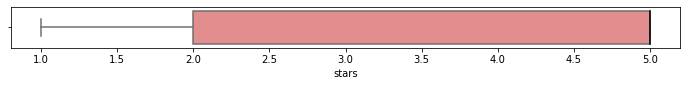

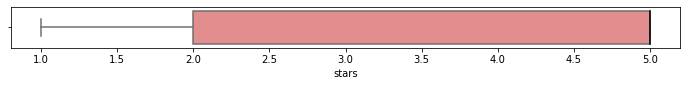

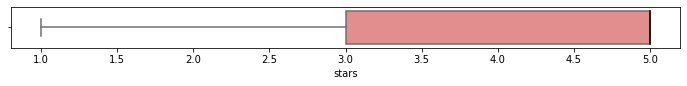

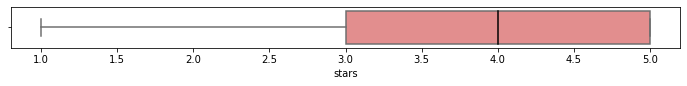

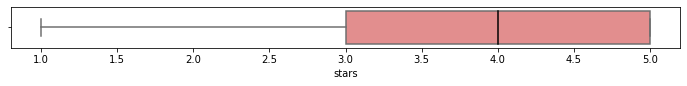

In [280]:
review_count = user_data.review_count.sum()
#print('The users in user_data collectively wrote', review_count,'reviews')

#binning by review count
user_data_without_outliers['binned_review'] = pd.qcut(user_data_without_outliers['review_count'], 5,labels = ['1','2','3','4','5'])

#indexes of user bins
user_data_without_outliers.set_index(keys = user_data_without_outliers['user_id'], inplace = True)
index_1 = user_data_without_outliers.index[user_data_without_outliers.binned_review == '1']
index_2 = user_data_without_outliers.index[user_data_without_outliers.binned_review == '2']
index_3 = user_data_without_outliers.index[user_data_without_outliers.binned_review == '3']
index_4 = user_data_without_outliers.index[user_data_without_outliers.binned_review == '4']
index_5 = user_data_without_outliers.index[user_data_without_outliers.binned_review == '5']

#grouping review data based on user bins
review_data.set_index(keys = review_data['user_id'], inplace=True)
crop1_allbusinesses = review_data.loc[index_1,:]
crop2_allbusinesses = review_data.loc[index_2,:]
crop3_allbusinesses = review_data.loc[index_3,:]
crop4_allbusinesses = review_data.loc[index_4,:]
crop5_allbusinesses = review_data.loc[index_5,:]

crop1sample = crop1_allbusinesses.sample(20000)
crop2sample = crop2_allbusinesses.sample(20000)
crop3sample = crop3_allbusinesses.sample(20000)
crop4sample = crop4_allbusinesses.sample(20000)
crop5sample = crop5_allbusinesses.sample(20000)

#boxplot for users with 0-4 reviews
a = sns.boxplot(data = crop1sample,x = 'stars',medianprops={"color": "black"}, color='lightcoral')
a.figure.set_figheight(0.75)
plt.show()

#boxplot for user with 5-9 reviews
a = sns.boxplot(data = crop2sample,x = 'stars',medianprops={"color": "black"}, color='lightcoral')
a.figure.set_figheight(0.75)
plt.show()

#boxplot for users with 10-18 reviews
a = sns.boxplot(data = crop3sample,x = 'stars',medianprops={"color": "black"}, color='lightcoral')
a.figure.set_figheight(0.75)
plt.show()

#boxplot for users with 19-36 reviews
a = sns.boxplot(data = crop4sample,x = 'stars',medianprops={"color": "black"}, color='lightcoral')
a.figure.set_figheight(0.75)
plt.show()

#boxplot for users with 37-108 reviews
a = sns.boxplot(data = crop5sample,x = 'stars',medianprops={"color": "black"}, color='lightcoral')
a.figure.set_figheight(0.75)
plt.show()

As the number of reviews written increased, the box of the boxplots became smaller in length and the median decreased. This led us to believe that as a user writes more reviews, the number of five star reviews must decrease. However, this was too difficult to tell from the boxplots and better visualizations were needed. We created another set of 5 graphs. We used the same sample of 20,000 reviews for each group of users to create 5 bar plots which showed the count of 1,2,3,4, and 5-star reviews. 

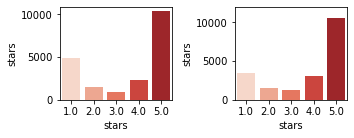

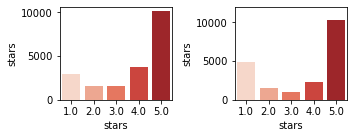

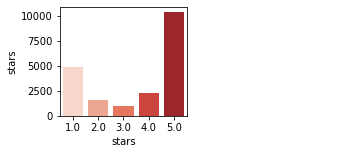

In [298]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
#barplot for users with 0-4 reviews
colors = ['lightcoral', 'indianred', 'firebrck', 'maroon','crimson']
crop1sample.reset_index(inplace=True, drop=True)
a = sns.barplot(data = crop1sample, x='stars', y='stars', estimator= len, palette='Reds', ax = ax[0])
plt.ylim(0, 12000)
a.figure.set_figheight(2)

#barplot for users with 5-9 reviews
crop2sample.reset_index(inplace=True, drop=True)
a = sns.barplot(data = crop2sample, x='stars', y='stars', estimator= len, palette='Reds', ax = ax[1])
plt.ylim(0, 12000)
a.figure.set_figheight(2)
fig.tight_layout(pad = 1)
fig.show()

fig, ax = plt.subplots(nrows = 1, ncols = 2)
#barplot for users with 10-18 reviews
crop3sample.reset_index(inplace=True, drop=True)
a = sns.barplot(data = crop3sample, x='stars', y='stars', estimator= len, palette = 'Reds', ax = ax[0])
plt.ylim(0, 12000)
a.figure.set_figheight(2)

#barplot for users with 19-36 reviews
crop4sample.reset_index(inplace=True, drop=True)
a = sns.barplot(data = crop1sample, x='stars', y='stars', estimator= len, palette='Reds', ax = ax[1])
plt.ylim(0, 12000)
a.figure.set_figheight(2)
fig.tight_layout(pad = 1)
fig.show()

fig, ax = plt.subplots(nrows = 1, ncols = 2)
#barplot for users with 37-108 reviews
crop5sample.reset_index(inplace=True, drop=True)
a = sns.barplot(data = crop1sample, x='stars', y='stars', estimator= len, palette='Reds', ax = ax[0])
plt.ylim(0, 12000)
a.figure.set_figheight(2)
ax[-1].axis('off')
fig.show()

We found that there was only slight variation between the 5 groups. There seemed to be a trend of 1 and 5-star reviews decreasing and 2,3, and 4-star reviews increasing as user review count increased, as we had expected. However, this trend was only true for the first three groups of users. The star counts of the last two groups looked very similar to the counts of the first group. This trend leads us to believe that there may be a ‘sweet spot’ for a user’s reviews count where their reviews have the least amount of bias. It is possible that users who write very little reviews give more 1 and 5-star reviews because they only write reviews sporadically when they are extremely dissatisfied or satisfied. As users write more reviews they are more likely to write 2,3, and 4-star reviews because they write reviews even when their opinion is not extreme; they use Yelp more frequently. Then after the sweet spot of 10-18 reviews, a user begins to write more extreme reviews because they become more critical of businesses. This is just one possible explanation for the trend seen. Lastly, we wanted to test review usefulness as a metric as it could show us more insight into our previous findings. Review usefulness is calculated based on how many users vote that a review is useful. First, in order to see the most useful reviews, we created a separate data frame of the 90th percentile of reviews based on useful votes. We created another bar plot of the star count for a random sample of 20,000 of the most useful reviews. 

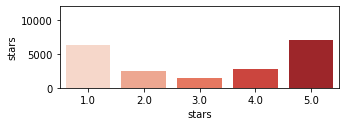

5.0    1060549
4.0     489663
1.0     339425
3.0     231128
2.0     179235
Name: stars, dtype: int64

In [291]:
index_no_outlier = user_data_without_outliers.index
review_data_no_outliers = review_data[review_data.index.isin(index_no_outlier)]
review_data_usefulness_sort = review_data_no_outliers.sort_values(by='useful', ascending=False)
most_useful_q3 = np.percentile(review_data_usefulness_sort['useful'],90)
#most_useful_q3 - most useful was 3.0
most_useful_reviews = review_data_usefulness_sort[review_data_usefulness_sort['useful']>3]

usefulsample = most_useful_reviews.sample(20000)
usefulsample.reset_index(inplace=True, drop=True)
plt.rcParams["figure.figsize"] = (5,4)
a = sns.barplot(data = usefulsample, x='stars', y='stars', estimator= len, palette='Reds')
plt.ylim(0, 12000)
a.figure.set_figheight(1.5)
plt.show()

review_data.stars.value_counts()

The barplot  had a similar U shape but the number of 5-star reviews decreased dramatically. The plot looked most similar to the plot of the ‘sweet spot’ group. We assumed that this was likely because many businesses offer promotions and discounts if their customers give them a 5-star Yelp review. It is important to note that about half of the reviews in our 2.3 billion review sample were 5-star reviews. So, most reviews written on yelp are 5-star reviews. Therefore, a greater proportion of 5-star reviews are not useful than any other star. These reviews are biased which is why they probably do not get as many useful votes. We also made a barplot that showed average review usefulness for each of the five groups of users we created earlier. The plot showed that users who wrote more reviews also wrote reviews that were more useful on average. 

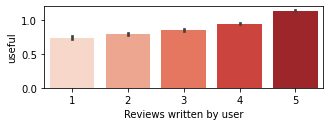

In [292]:
crop1_allbusinesses['crop']=1
crop2_allbusinesses['crop']=2
crop3_allbusinesses['crop']=3
crop4_allbusinesses['crop']=4
crop5_allbusinesses['crop']=5

data_all_crops = pd.concat([crop1_allbusinesses,crop2_allbusinesses,crop3_allbusinesses,crop4_allbusinesses,crop5_allbusinesses],keys = ['Least Reviews','Less Reviews','Middle Reviews','More Reviews','Most Reviews'])

ax = sns.barplot(data = data_all_crops, x = 'crop', y = 'useful', palette='Reds')
ax.set_xlabel('Reviews written by user')
ax.figure.set_figheight(1.5)

## Recommendations to stakeholder(s)

We recommend that owners of restaurant and nightlife businesses divert resources to the creation of a Yelp team that has the responsibility of upholding and improving the businesses’ online/Yelp reputation; within the category of restaurants, seafood restaurants should especially prioritize this. Restaurant-type and nightlife-type businesses stood out from the rest in terms of average reviews per business, and seafood-type restaurants stood out from other restaurants in this same measure. A higher number of reviews per business indicates a higher level of interaction between Yelp users and those businesses, and in turn higher Yelp traffic. Without a strong Yelp reputation, businesses in high-traffic categories are not only missing out on these potential consumers, but losing them to competitors. They need to create a strong presence on Yelp to capitalize on the high traffic of their industry and gain an edge over their competitors, and a Yelp team could help these businesses accomplish this. A limitation of this is that this analysis does not address the relationship between Yelp traffic and profits. It would be beneficial to determine if higher Yelp traffic is correlated with higher profits, and what proportion of these businesses’ consumer base comes from Yelp. This further information would help determine if this recommendation is likely to increase profits, or just good in theory.
 
When it comes to ratings, both closed and open businesses had similar distributions of average rating and the total number of reviews they received. So, not much can be taken away from this analysis. We noticed that open businesses offer more lot parking, and closed restaurants offered more street parking. Thus, we can conclude that offering street parking may have had something to do with the business’s failure – perhaps because street parking is seen as less safe and less convenient than lot parking. So, we would recommend businesses to offer more lot parking and less street parking. The proportion of open and closed businesses who operated on weekends were extremely similar, so whether or not they operated on weekends seems to have little relationship to whether they shut down. However, from the histogram of total hours of operation, we could see that open businesses opened for less hours each week than closed businesses. It’s possible that they opened for less hours but made better use of that time, allowing them to still generate business while cutting down unnecessary hours/costs of operation. Thus, we would recommend businesses to cut down hours of operations to only high-traffic hours (ex. If they don’t get a lot of businesses in the early morning hours, maybe consider closing during those low-profit hours to save on operating costs).

Furthermore, we noticed that postal codes that had residents with greater proportions of black or African American residents and lower mean household incomes across all metropolitan areas had poorer online presences for businesses, as measured by the pairwise correlations between these demographic variables and the average stars. From these findings, we suggest that local government officials for all metropolitan areas should implement grants or loans for businesses specifically for postal codes with lower mean household incomes or higher proportions of Black or African American residents to improve overall online business performance and success. Further, specific action must be taken in cities like Los Angeles, Reno, Boise, and St. Louis that have significantly stronger pairwise correlations, indicating further need for even greater stimulus overall from state government officials targeted at the specific postal codes with aforementioned demographic characteristics.
 
We found that the ‘sweet spot’ for the least amount of bias in a rating was when a user had written 10-18 reviews. We also found that most bias exists in 5-star reviews which is likely due to businesses giving promotions to customers who give them a 5-star review. Thus, our recommendation to users is to refrain from participating in promotions that reward yelp reviews in order for business ratings to be as accurate as possible. We also recommend that users write reviews when they find a business mediocre and not solely when they feel an extreme emotion toward a business. Our recommendation to Yelp executives/programmers is to consider giving more useful reviews a greater weight than non useful reviews to help limit bias in business’ overall rating. 

## References {-}

List and number all bibliographical references. When referenced in the text, enclose the citation number in square brackets, for example [1].

[1] Blog, Yelp – Official, and John Carroll. “The Complete Yelp Business Category List.” Yelp, 13 July 2022, https://blog.yelp.com/businesses/yelp_category_list/#section21. 
 
[2] leoleo 32344 silver badges1212 bronze badges, et al. “Return All Substrings from a List of Strings in a Dataframe Column.” Stack Overflow, 1 Nov. 1966, https://stackoverflow.com/questions/57948850/return-all-substrings-from-a-list-of-strings-in-a-dataframe-column. 


## Appendix {-}

In [284]:
display(review_data.isnull().sum())
display(user_data.isnull().sum())

review_id      0
user_id        0
business_id    0
stars          0
useful         0
text           0
date           0
dtype: int64

user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
fans                  0
average_stars         0
compliment_profile    0
dtype: int64